In [ ]:
# TODO

In [1]:
# imports
import os
import random
from itertools import chain
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from utils import load_image
from utils.face_detection import plot_face_detection, get_face_keypoints_detecting_function
from utils.mask_generator import load_mask_patterns, create_mask_keypoints_generator, get_face_with_mask

In [2]:
# parameters
path_to_data = 'data/lfw-deepfunneled'
path_to_face_with_mask_image = 'data/face_with_mask.jpg'
path_to_patterns = 'data/mask_patterns'
minimal_confidence = 0.8
hyp_ratio = 1 / 3
coordinates_range = (-10, 10)

In [3]:
# setup HW
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
# disable Error logging
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [5]:
# prepare functions
face_keypoints_detecting_fun = get_face_keypoints_detecting_function(minimal_confidence)
keypoints_for_mask_fun = create_mask_keypoints_generator(coordinates_range)

In [6]:
# load the dataset
# find-out all image files
files_faces = list(
    chain.from_iterable(
        [["{}/{}".format(folder, sub_folder) for sub_folder in os.listdir(os.path.join(path_to_data, folder))]
         for folder in os.listdir(path_to_data)]
    )
)
print("Samples: ", len(files_faces))

Samples:  13233


In [9]:
# load patterns for masks
patterns = load_mask_patterns(path_to_patterns, True, False)

In [10]:
from PIL import Image
from typing import Optional, Tuple

from utils.face_detection import compute_slacks


def crop_face(image: Image, face_keypoints: Optional, hyp_ratio: float = 1/3) -> Image:

    # no cropping - no face was detected
    if face_keypoints is None:
        return image

    # get bounding box
    x, y, width, height = face_keypoints['box']

    # compute slacks
    w_s, h_s = compute_slacks(height, width, hyp_ratio)

    # compute coordinates
    left = min(max(0, x - w_s), image.width)
    upper = min(max(0, y - h_s), image.height)
    right = min(x + width + w_s, image.width)
    lower = min(y + height + h_s, image.height)

    return image.crop((left, upper, right, lower))

def crop_mask(mask, face_keypoints: Optional, hyp_ratio: float = 1/3):
    if face_keypoints is None:
        return mask
    x, y, width, height = face_keypoints['box']
    w_s, h_s = compute_slacks(height, width, hyp_ratio)
    return mask[max(0, y - int(h_s)):y + height + int(h_s), max(0, x - int(w_s)):x + width + int(w_s)]

def pad_and_resize_image(image: Image, height: int = 256, width: int = 256):

    # compute ratio of current height and width to target
    h_ratio = image.height / height
    w_ratio = image.width / width

    # resize image if any side is greater then target
    if h_ratio > 1 or w_ratio > 1:
        if h_ratio > w_ratio:
            print()
        else:
            print()



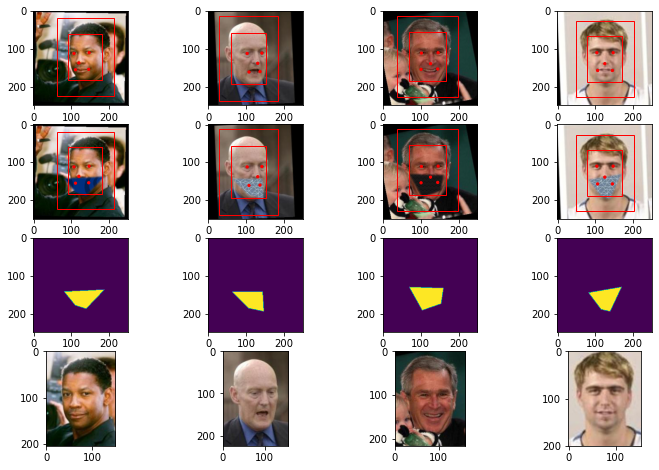

In [11]:
# show a few annotated faces
fig, axes = plt.subplots(4, 4, figsize=(12, 8))
for i, file in enumerate(random.sample(files_faces, 4)):
    image = load_image("{}/{}".format(path_to_data, file))

    # detect keypoints
    keypoints = face_keypoints_detecting_fun(image)

    # create image with a mask
    (image_with_mask, mask_values) = get_face_with_mask(image, patterns, keypoints, keypoints_for_mask_fun)

    # crop image
    cropped_image = crop_face(image, keypoints)

    plot_face_detection(image, axes[0][i], keypoints, hyp_ratio)
    plot_face_detection(image_with_mask, axes[1][i], keypoints, hyp_ratio)
    plot_face_detection(mask_values, axes[2][i], None, hyp_ratio)
    plot_face_detection(cropped_image, axes[3][i], None, hyp_ratio)

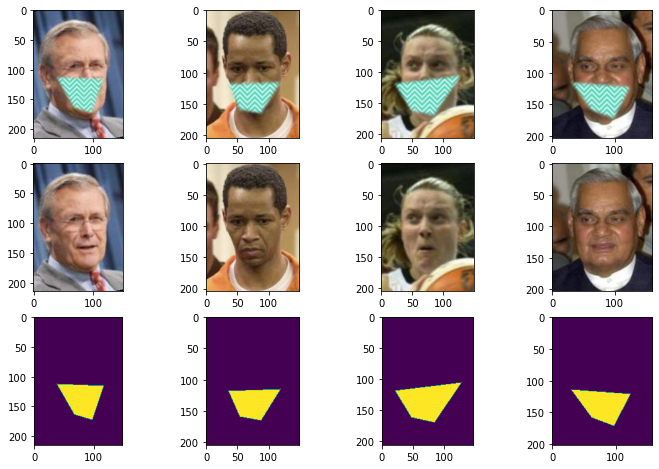

In [10]:
n = 4
fig, axes = plt.subplots(3, n, figsize=(12, 8))
for i, file in enumerate(random.sample(files_faces, n)):
    image = load_image("{}/{}".format(path_to_data, file))
    keypoints = face_keypoints_detecting_fun(image)
    (image_with_mask, mask_values) = get_face_with_mask(image, patterns, keypoints, keypoints_for_mask_fun)
    cropped_image = crop_face(image_with_mask, keypoints)
    cropped_original = crop_face(image, keypoints)
    cropped_mask = crop_mask(mask_values, keypoints)
    
    plot_face_detection(cropped_image, axes[0][i], None, hyp_ratio)
    plot_face_detection(cropped_original, axes[1][i], None, hyp_ratio)
    plot_face_detection(cropped_mask, axes[2][i], None, hyp_ratio)

In [1]:
from utils.model import Mask2FaceModel
model = Mask2FaceModel()
model.train(1)

150/150 [==============================] - 23s 151ms/step - loss: 0.0158 - acc: 0.0071 - recall: 0.4733 - precision: 0.9997 - iou: 0.3983 - val_loss: 0.0376 - val_acc: 0.0060 - val_recall: 0.5685 - val_precision: 0.9998 - val_iou: 0.3421 - lr: 1.0000e-04


In [1]:
from utils.model import Mask2FaceModel
model = Mask2FaceModel()
model.load_model('model_epochs-20_batch-20_loss-MSE_20201207_13_58_14.h5')
model.predict_batch()

In [14]:
# crop, pad and resize images
gt = []
inputs = []
outputs = []
original_size = []

img_size = (256, 256)
n = 150
for i, file in enumerate(random.sample(files_faces, n)):
    # Load images
    image = load_image("{}/{}".format(path_to_data, file))
    
    # Detect keypoints on face
    keypoints = face_keypoints_detecting_fun(image)
    
    # Genereate mask
    try:
        (image_with_mask, mask_values) = get_face_with_mask(image, patterns, keypoints, keypoints_for_mask_fun)
    except:
        continue
    
    # Crop images
    cropped_image = crop_face(image_with_mask, keypoints)
    cropped_original = crop_face(image, keypoints)
    cropped_mask = crop_mask(mask_values, keypoints)
      
        
    # Resize all images to NN input size
    res_image = cropped_image.resize(img_size)
    res_original = cropped_original.resize(img_size)
    mask_image = Image.fromarray(cropped_mask)
    mask_image = mask_image.resize(img_size)
    res_mask = np.array(mask_image)
    
    # Save pictures to folder
    shift = 0
    train_folder = 'test_pattern'
    res_image.save(f"data/{train_folder}/inputs/{i+shift}.png")
    res_original.save(f"data/{train_folder}/outputs/{i+shift}.png")
#     mask_image.save(f"data/{train_folder}/masks/{i}.png")
    
#     cv2.imwrite(f"data/inputs/{i}.png", np.array(res_image))
#     cv2.imwrite(f"data/outputs/{i}.png", np.array(res_original))
#     cv2.imwrite(f"data/masks/{i}.png", np.array(res_mask))
    
    # Save generated data to lists
#     gt.append(res_original)
#     inputs.append(res_image)
#     outputs.append(res_mask)
#     original_size.append(cropped_image.size)

In [12]:
ALLOWED_PATTERNS_TYPES = ('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')
a = [Image.open("{}/{}".format(path_to_patterns, file)) for file in os.listdir(path_to_patterns) if file.lower().endswith(ALLOWED_PATTERNS_TYPES)]

In [13]:
a

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=96x96 at 0x7FAC90365CD0>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=286x200 at 0x7FACEC03F3D0>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2560x1600 at 0x7FAC9036C220>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1600x900 at 0x7FACE032E550>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x448 at 0x7FACE032E4C0>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=350x350 at 0x7FACE032E3A0>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=550x250 at 0x7FACE032E580>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=300x300 at 0x7FACE032E5E0>]

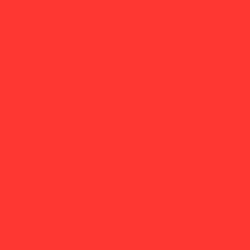

In [15]:
Image.new('RGBA', image.size, (255, 55, 50))

In [10]:
import random
from PIL import Image
color = []
step = 50
for r in range(0,256,step):
    for g in range(0,256,step):
        for b in range(0,256,step):
            color.append(Image.new('RGB', (100,100), (r,g,b)))
print(len(color))
random.shuffle(color)
print(color)

216
[<PIL.Image.Image image mode=RGB size=100x100 at 0x7F13864D64F0>, <PIL.Image.Image image mode=RGB size=100x100 at 0x7F1386431F70>, <PIL.Image.Image image mode=RGB size=100x100 at 0x7F13941205E0>, <PIL.Image.Image image mode=RGB size=100x100 at 0x7F13864CAB50>, <PIL.Image.Image image mode=RGB size=100x100 at 0x7F13864D6C10>, <PIL.Image.Image image mode=RGB size=100x100 at 0x7F13940D8250>, <PIL.Image.Image image mode=RGB size=100x100 at 0x7F1394120400>, <PIL.Image.Image image mode=RGB size=100x100 at 0x7F13864D6B80>, <PIL.Image.Image image mode=RGB size=100x100 at 0x7F139411B490>, <PIL.Image.Image image mode=RGB size=100x100 at 0x7F13864D6310>, <PIL.Image.Image image mode=RGB size=100x100 at 0x7F13864316D0>, <PIL.Image.Image image mode=RGB size=100x100 at 0x7F139411B550>, <PIL.Image.Image image mode=RGB size=100x100 at 0x7F13864CAC70>, <PIL.Image.Image image mode=RGB size=100x100 at 0x7F1386431FD0>, <PIL.Image.Image image mode=RGB size=100x100 at 0x7F139411B6D0>, <PIL.Image.Image ima